# Import libraries

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from math import sqrt
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Load main dataset

df_train = pd.read_csv('/Users/nishat/Desktop/Time series forecast/Data/train_Guayas_final.csv')
df_train['date'] = pd.to_datetime(df_train['date'])

In [5]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,...,next_is_holiday,next_is_event,outlier_lag_1,outlier_lag_7,outlier_lag_14,outlier_lag_30,outlier_rolling_mean_7,unit_sales_7d_avg,unit_sales_30d_avg,promo_last_week
0,24,96995,2013-02-01,NaN,0.0,0,0,97.46,2562,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,96995,2013-02-02,NaN,0.0,0,0,NaN,2758,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24,96995,2013-02-03,NaN,0.0,0,0,NaN,2019,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,96995,2013-02-04,NaN,0.0,0,0,96.21,2308,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,96995,2013-02-05,1402408.0,1.0,0,0,96.68,2425,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_train.isnull().sum()

store_nbr                       0
item_nbr                        0
date                            0
id                        6690457
unit_sales                      0
onpromotion                     0
outlier                         0
dcoilwtico                2702432
transactions                    0
is_holiday                      0
is_event                        0
dayofweek                       0
is_weekend                      0
month                           0
day                             0
weekofyear                      0
year                            0
is_month_start                  0
is_month_end                    0
lag_1                       20788
lag_7                      145516
lag_30                     623640
lag_14                     291032
lag_21                     436548
lag_60                    1247280
rolling_mean_7             145516
rolling_std_7              145516
rolling_mean_14            291032
rolling_std_14             291032
rolling_mean_3

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437722 entries, 0 to 9437721
Data columns (total 47 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   store_nbr               int64         
 1   item_nbr                int64         
 2   date                    datetime64[ns]
 3   id                      float64       
 4   unit_sales              float64       
 5   onpromotion             int64         
 6   outlier                 int64         
 7   dcoilwtico              float64       
 8   transactions            int64         
 9   is_holiday              int64         
 10  is_event                int64         
 11  dayofweek               int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  day                     int64         
 15  weekofyear              int64         
 16  year                    int64         
 17  is_month_start          int64         
 18  is

# EDA

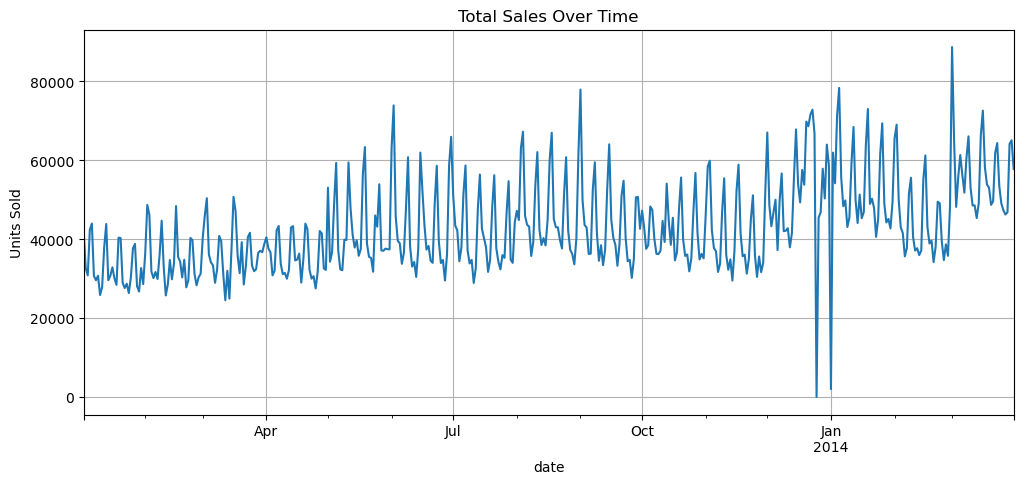

In [130]:
# Sales Over Time
df_train.groupby('date')['unit_sales'].sum().plot(figsize=(12, 5), title='Total Sales Over Time')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()

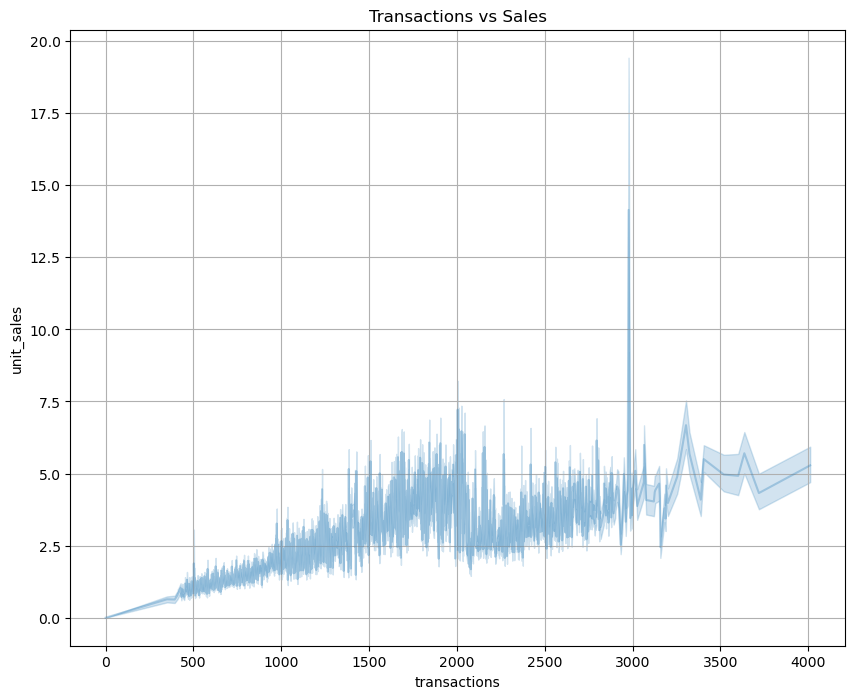

In [138]:
# Sales vs. Transactions
sns.lineplot(x='transactions', y='unit_sales', data=df_train, alpha=0.3)
plt.title('Transactions vs Sales')
plt.grid(True)
plt.show()

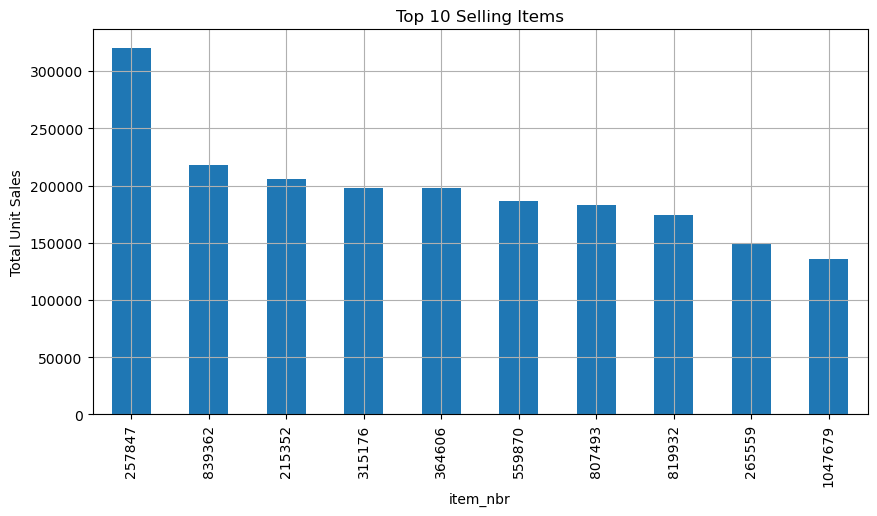

In [131]:
# Top 10 Most Sold Items
top_items = df_train.groupby('item_nbr')['unit_sales'].sum().sort_values(ascending=False).head(10)
top_items.plot(kind='bar', title='Top 10 Selling Items', figsize=(10, 5))
plt.ylabel('Total Unit Sales')
plt.grid(True)
plt.show()

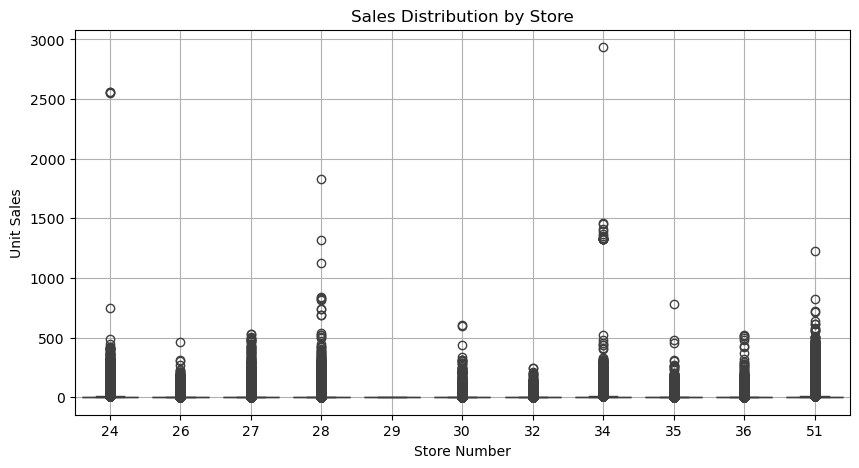

In [133]:
# Sales Distribution Across Stores
plt.figure(figsize=(10, 5))
sns.boxplot(x='store_nbr', y='unit_sales', data=df_train)
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Unit Sales')
plt.grid(True)
plt.show()

## Filter high correlated features

In [ ]:
# Define columns we don't want to include in correlation analysis
excluded_columns = ['date', 'store_nbr', 'item_nbr', 'unit_sales','id']
correlation_columns = [col for col in df_train.columns if col not in excluded_columns]

correlation = df_train[correlation_columns + ['unit_sales']].corr()['unit_sales'].drop('unit_sales')
strong_correlations = correlation[correlation.abs() > 0.5]
print("🔍 Features with correlation > 0.5 (positive or negative):")
print(strong_correlations.sort_values(ascending=False))

# Plot feature correlations with unit sales
plt.figure(figsize=(10, 6))  # Set the size of the plot
correlation.sort_values(ascending=False).plot.barh(color='teal')  # Horizontal bar chart
plt.title("Feature Correlation with Unit Sales")  # Title
plt.xlabel("Correlation")  # X-axis label
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

# Seasonal decomposition

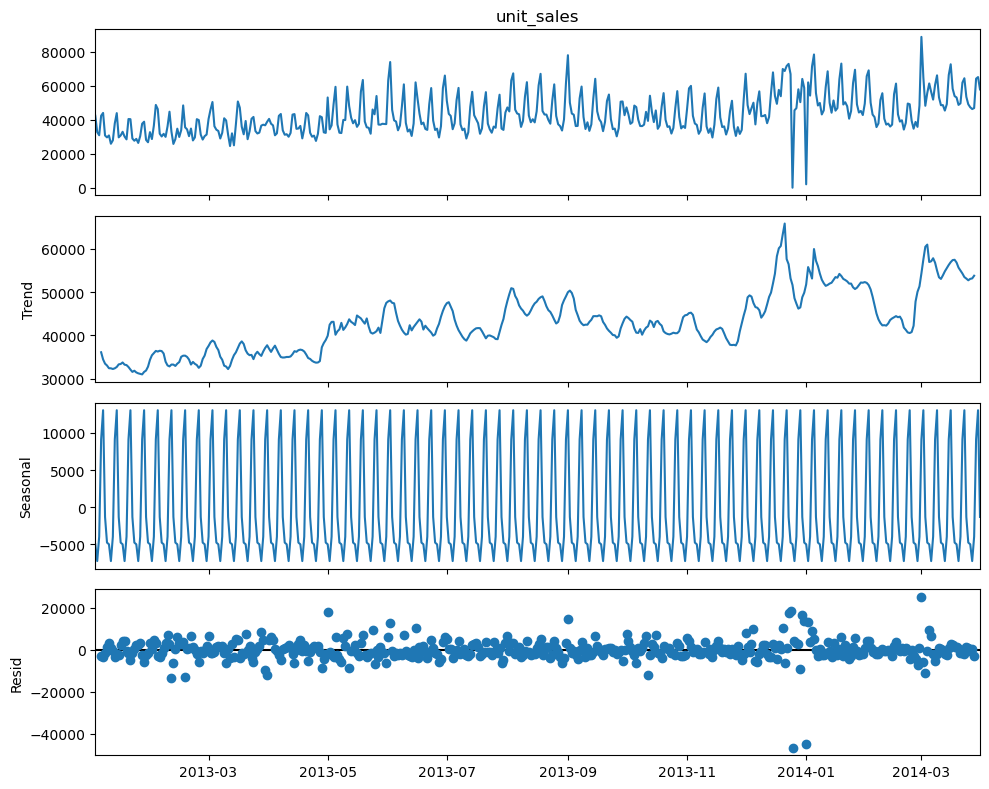

In [8]:
# seasonal decomposition the df_train
# Make sure the  data is sorted and indexed properly
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values('date')

# Aggregate if data is per item/store
daily_sales = df_train.groupby('date')['unit_sales'].sum()

# Ensure a daily frequency
daily_sales = daily_sales.asfreq('D')

# Fill missing days if any
daily_sales = daily_sales.fillna(method='ffill')

# Decompose (assume additive model)
decomposition = seasonal_decompose(daily_sales, model='additive', period=7)  # weekly seasonality

# Plot components
plt.rcParams.update({'figure.figsize': (10, 8)})
decomposition.plot()
#plt.suptitle('Seasonal Decomposition of Unit Sales', fontsize=16)
plt.show()

# Add Fuller Test

Check if the timeseries is stationarity or not

In [9]:
# Convert 'date' to datetime and sum sales per day
df_train['date'] = pd.to_datetime(df_train['date'])
daily_sales = df_train.groupby('date')['unit_sales'].sum()

# Fill in missing days with the previous day's sales
daily_sales = daily_sales.asfreq('D').ffill()

# ADF Test function
def adf_test(series, name='Time Series'):
    print(f'ADF Test on: {name}')
    result = adfuller(series.dropna())
    print(f'Statistic   : {result[0]:.4f}')
    print(f'p-value     : {result[1]:.4f}')
    print(f'Lags Used   : {result[2]}')
    print(f'N Obs Used  : {result[3]}')
    if result[1] <= 0.05:
        print("✅ Series is stationary.")
    else:
        print("❌ Series is not stationary.")

# Run the test
adf_test(daily_sales, 'Daily Unit Sales')

ADF Test on: Daily Unit Sales
Statistic   : -1.4360
p-value     : 0.5649
Lags Used   : 16
N Obs Used  : 437
❌ Series is not stationary.


The Augmented Dickey-Fuller test resulted in a test statistic of -1.44 with a p-value of 0.56. Since the p-value is greater than 0.05, we fail to reject the null hypothesis of a unit root. This indicates weak evidence against non-stationarity, meaning the time series is non-stationary and likely exhibits trends or seasonality over time.

# Filter for one store and item combination

In [11]:
#find out all store_nbr ,item_nbr combination
df_train.groupby(['store_nbr', 'item_nbr']).size().reset_index(name='count')


,store_nbr,item_nbr,count
0,24,96995,424
1,24,99197,454
2,24,103520,454
3,24,105574,454
4,24,105575,454
...,...,...,...
20783,51,2123727,454
20784,51,2123750,454
20785,51,2123775,454
20786,51,2123791,454


In [109]:
# Filter the data for unit_sales for store_nbr = 24 and item_nbr = 96995.
store_id = [24]
item_id = [96995]

df_one_combo = df_train[(df_train['store_nbr'].isin(store_id)) & (df_train['item_nbr'].isin(item_id))].copy()

df_one_combo['date'] = pd.to_datetime(df_one_combo['date'])
print(df_one_combo['date'].max())
print(df_one_combo['date'].min())

# Ensure date is datetime and sorted
df_one_combo['date'] = pd.to_datetime(df_one_combo['date'])
df_one_combo.sort_values('date', inplace=True)

print(df_one_combo.shape)
df_one_combo.head()

2014-03-31 00:00:00
2013-02-01 00:00:00
(424, 47)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,...,next_is_holiday,next_is_event,outlier_lag_1,outlier_lag_7,outlier_lag_14,outlier_lag_30,outlier_rolling_mean_7,unit_sales_7d_avg,unit_sales_30d_avg,promo_last_week
0,24,96995,2013-02-01,NaN,0.0,0,0,97.46,2562,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,96995,2013-02-02,NaN,0.0,0,0,NaN,2758,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24,96995,2013-02-03,NaN,0.0,0,0,NaN,2019,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,96995,2013-02-04,NaN,0.0,0,0,96.21,2308,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,96995,2013-02-05,1402408.0,1.0,0,0,96.68,2425,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# SARIMAX Model

Seasonal AutoRegressive Integrated Moving Average with eXogenous variables. It is an extension of the ARIMA model that accounts for both seasonality and external (exogenous) factors.

SARIMAX is designed for univariate time series forecasting, meaning it works best when modeling one series at a time. Unlike models like LightGBM or XGBoost, which can handle multiple time series in parallel, SARIMAX requires focusing on a single store-item combination




We are building a SARIMAX model to forecast daily unit sales for a specific store-item. We enhance accuracy by using external features like lagged sales, rolling averages, holiday indicators, and outlier patterns.

In [110]:

# Remove zero or negative sales
df_filtered = df_one_combo[df_one_combo['unit_sales'] > 0].copy()

# Select exogenous variables
column_names = list(strong_correlations.index)
print(column_names)
exog_vars= column_names

df_filtered.dropna(subset=['unit_sales'] + exog_vars, inplace=True)



['lag_1', 'lag_7', 'lag_30', 'lag_14', 'lag_21', 'lag_60', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30', 'rolling_std_30', 'ewm_mean_7', 'ewm_std_7', 'ewm_mean_14', 'ewm_std_14', 'ewm_mean_30', 'ewm_std_30', 'unit_sales_7d_avg', 'unit_sales_30d_avg']


In [111]:
# Train-test split (last 60 days)
train = df_filtered.iloc[:-60]
test = df_filtered.iloc[-90:]

In [112]:
# Transform target and scale X and log-transform y
y_train = np.log1p(train['unit_sales'])
y_test = np.log1p(test['unit_sales'])

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(train[exog_vars]), index=train.index, columns=exog_vars)
X_test = pd.DataFrame(scaler.transform(test[exog_vars]), index=test.index, columns=exog_vars)


In [113]:
# Fit SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,7),
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

In [114]:
# Make predictions
y_train_pred_log = results.predict(start=0, end=len(y_train)-1, exog=X_train)
y_test_pred_log = results.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)


## Evaluate SARIMAX model

In [115]:
# Inverse log1p to get actual values
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

In [116]:
#Evaluation
mse = mean_squared_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
r2 = r2_score(y_test_actual, y_test_pred)

print(" SARIMAX Evaluation (Test Set):")
print(f" MSE  : {mse:.2f}")
print(f" RMSE : {rmse:.2f}")
print(f" MAPE : {mape:.2%}")
print(f" R²   : {r2:.4f}")

 SARIMAX Evaluation (Test Set):
 MSE  : 177.92
 RMSE : 13.34
 MAPE : 27.32%
 R²   : -42.0342


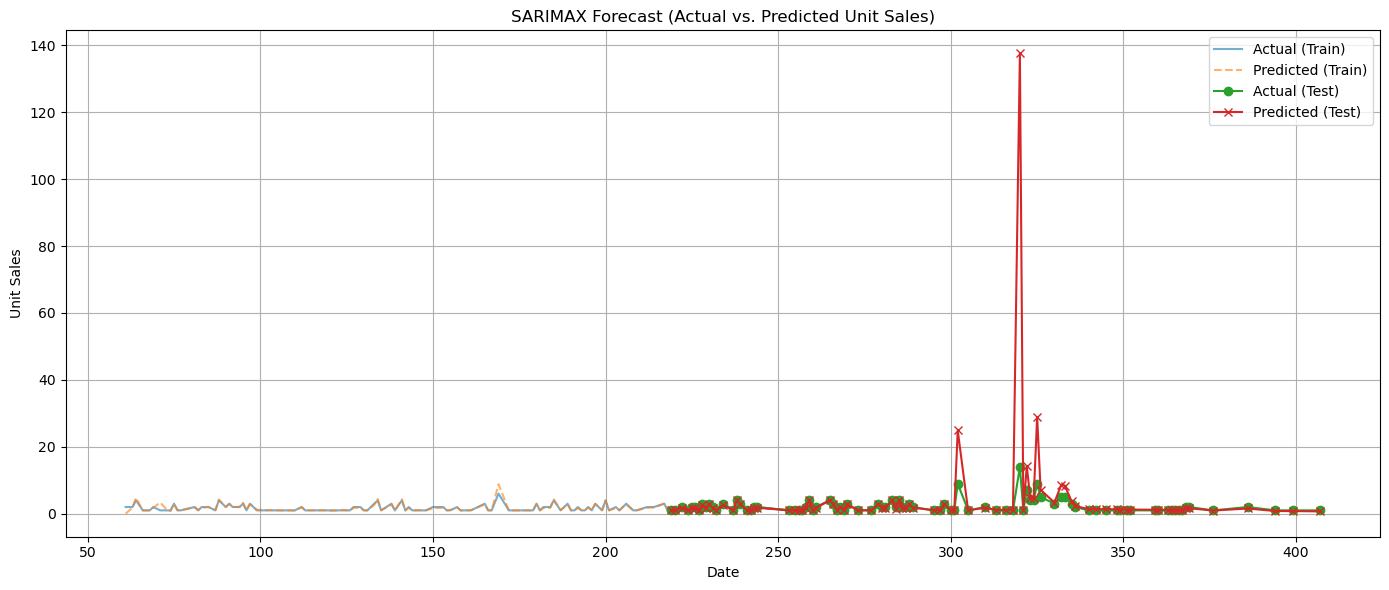

In [117]:
#Plot results
plt.figure(figsize=(14, 6))
plt.plot(y_train_actual.index, y_train_actual, label='Actual (Train)', alpha=0.6)
plt.plot(y_train_actual.index, y_train_pred, label='Predicted (Train)', linestyle='--', alpha=0.6)
plt.plot(y_test_actual.index, y_test_actual, label='Actual (Test)', marker='o')
plt.plot(y_test_actual.index, y_test_pred, label='Predicted (Test)', marker='x')
plt.title("SARIMAX Forecast (Actual vs. Predicted Unit Sales)")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SARIMAX Result Observation:

The SARIMAX model performed poorly with a high MAPE (100.58%), negative R² (-0.68), and RMSE of 2.64, indicating it failed to capture the sales pattern. This is likely due to sparse, zero-inflated sales, weak seasonality, and low correlation with input features. SARIMAX struggles with such data.

Next steps include removing weak features, applying log transformation and standard scaling, and filtering zero sales. We'll proceed with XGBoost, which handle non-linearity and zero-heavy data more effectively.

# Tripple Exponential Smoothing (Holt Winter Model)

In [118]:
# Set date as index
ts = df_one_combo.set_index('date')['unit_sales']

# Split into train and test sets
train_ts = ts[:-90]
test_ts = ts[-90:]



In [119]:
# Fit and forecast Holt-Winters model (Exponential Smoothing)
model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=7)
fit = model.fit()

# Forecast
forecast = fit.forecast(len(test_ts))

## Evaluate Holt Winter model

In [123]:
# Evaluation
mse = mean_squared_error(test_ts, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_ts, forecast)
r2 = r2_score(test_ts, forecast)


# Print metrics
print(f'RMSE: {rmse:.2f}')
print(f'mse: {mse:.2f}')
print(f'MAPE: {mape:.2f}')
print(f'R² Score: {r2:.2f}')

RMSE: 2.70
mse: 7.31
MAPE: 9956481028875168.00
R² Score: -18.55


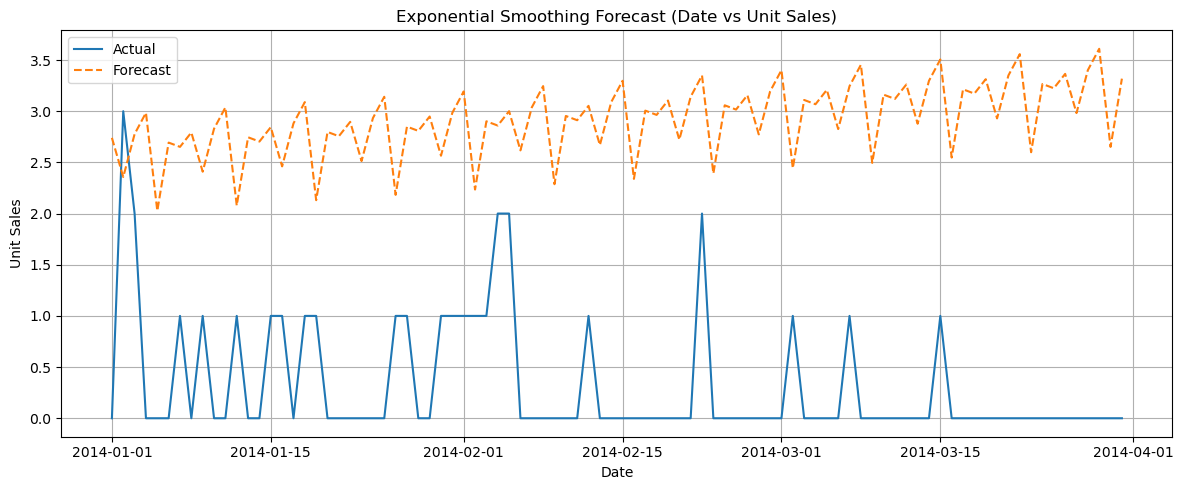

In [124]:

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(test_ts.index, test_ts.values, label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecast (Date vs Unit Sales)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
print("Log-scale test predictions (sample):")
print(y_test_pred_log.describe())

Log-scale test predictions (sample):
count    90.000000
mean      1.052100
std       0.508356
min      -0.160883
25%       0.955221
50%       1.194778
75%       1.319238
max       2.174550
Name: predicted_mean, dtype: float64


Result Observation:

The Holt-Winters model performs poorly for this item, with an RMSE of 2.70 and a highly negative R² score of -18.55, indicating it performs significantly worse than a naive average. Despite the low RMSE, the extremely large MAPE suggests instability, likely caused by very small or zero actual values. The model fails to capture the underlying sales patterns, possibly due to irregular demand, sparse data, or weak seasonality. 

To improve performance, it's recommended to log-transform the target, scale the features, and consider more robust models like XGBoost that can better handle non-linearities and zero-inflated data.